# **Microproyecto 1**
## **Generación de paleta de colores a partir de imágenes con técnicas de machine learning no supervisado**
Una paleta de colores es un conjunto de tonos que se utilizan juntos para crear un efecto armonioso, coherente y atractivo en las representaciones visuales (diseño gráfico, cine, fotografía, pintura, etc.), así como para transmitir mensajes y generar emociones determinados, de acuerdo con la intencionalidad del autor de la obra.

En un contexto de amplia demanda de herramientas que puedan asistir a diseñadores gráficos, directores de arte, pintores y creadores de contenido, entre otros, para la selección rápida y adecuada de los colores apropiados para sus obras, una aplicación para configurar paletas de colores a partir de imágenes sería de mucha utilidad. 

El problema central radica en desarrollar un método automatizado que pueda generar una paleta coherente y estéticamente atractiva partiendo de los colores identificados en una imagen. Esto implica no solo reconocer tonos dominantes, sino también comprender la relación existente al interior de la gama cromática empleada para crear combinaciones visuales agradables y funcionales. Abordar este problema se traduciría en varias ventajas:

Eficiencia en el proceso creativo, al liberar tiempo que los autores podrían emplear en otros aspectos estratégicos de sus proyectos.

Consistencia interna en los diseños, manteniendo una identidad visual constante en diferentes aplicaciones y proyectos.

Facilidad de uso y recurso de aprendizaje para personas con menos experiencia en diseño, fomentando la creatividad en diversos campos.

Optimización de la calidad y del impacto de la comunicación visual. 

Una vía para lograr una herramienta como esta es utilizar técnicas de machine learning no supervisado sobre imágenes para visualizar la distribución de los colores dominantes presentes en estas y generar, de manera automática, modelos de paletas de colores. En esta primera aproximación el método va a permitir identificar los colores dominantes en una imagen para construir un muestrario por similitud de píxeles, lo cual puede ser muy útil para estudios de marketing, psicología, medicina, arte, ambiente, entre otros. Por ejemplo, se podrían extraer los colores de las diferentes superficies de la Tierra en una imagen satelital para estudiar la distribución de la vegetación o de la contaminación.
### **A. Objetivo**

Desarrollar un método, basado en técnicas de agrupación, que permita extraer los tonos dominantes de una imagen y generar un muestrario de los colores representativos presentes en esta. 

### **B. Conjunto de datos**

Los datos están asociados con imágenes de obras de arte. Pueden ser descargados a partir de este
 enlace <a href="https://www.kaggle.com/datasets/steubk/wikiart" target="_blank">WikiArt</a>.
### **C. Actividades para realizar**

1. Recopilación de las imágenes a partir del repositorio. La idea es seleccionar un conjunto diverso de muestras en diferentes estilos artísticos (varios pintores). Se recomienda seleccionar entre 6 y 10 imágenes.

- Como primera medida se cargan las bibliotecas necesarias para el desarrollo del proyecto. 

In [83]:
#Importar bibliotecas
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# Variables globales
MAX_SIDE = 512
RAMDOM_STATE = 42

- A continuación, se cargan las imágenes seleccionadas para el análisis. El criterio de selección consistió en elegir una obra de arte de cada uno de los diez artistas más reconocidos y representativos de la historia del arte, abarcando diversos siglos y estilos artísticos. Entre ellos se encuentran: Monet, Diego Rivera, Frida Kahlo, Gustave Doré, Henri Matisse, Pablo Picasso, Auguste Renoir, Rembrandt, Vincent van Gogh y Salvador Dalí.

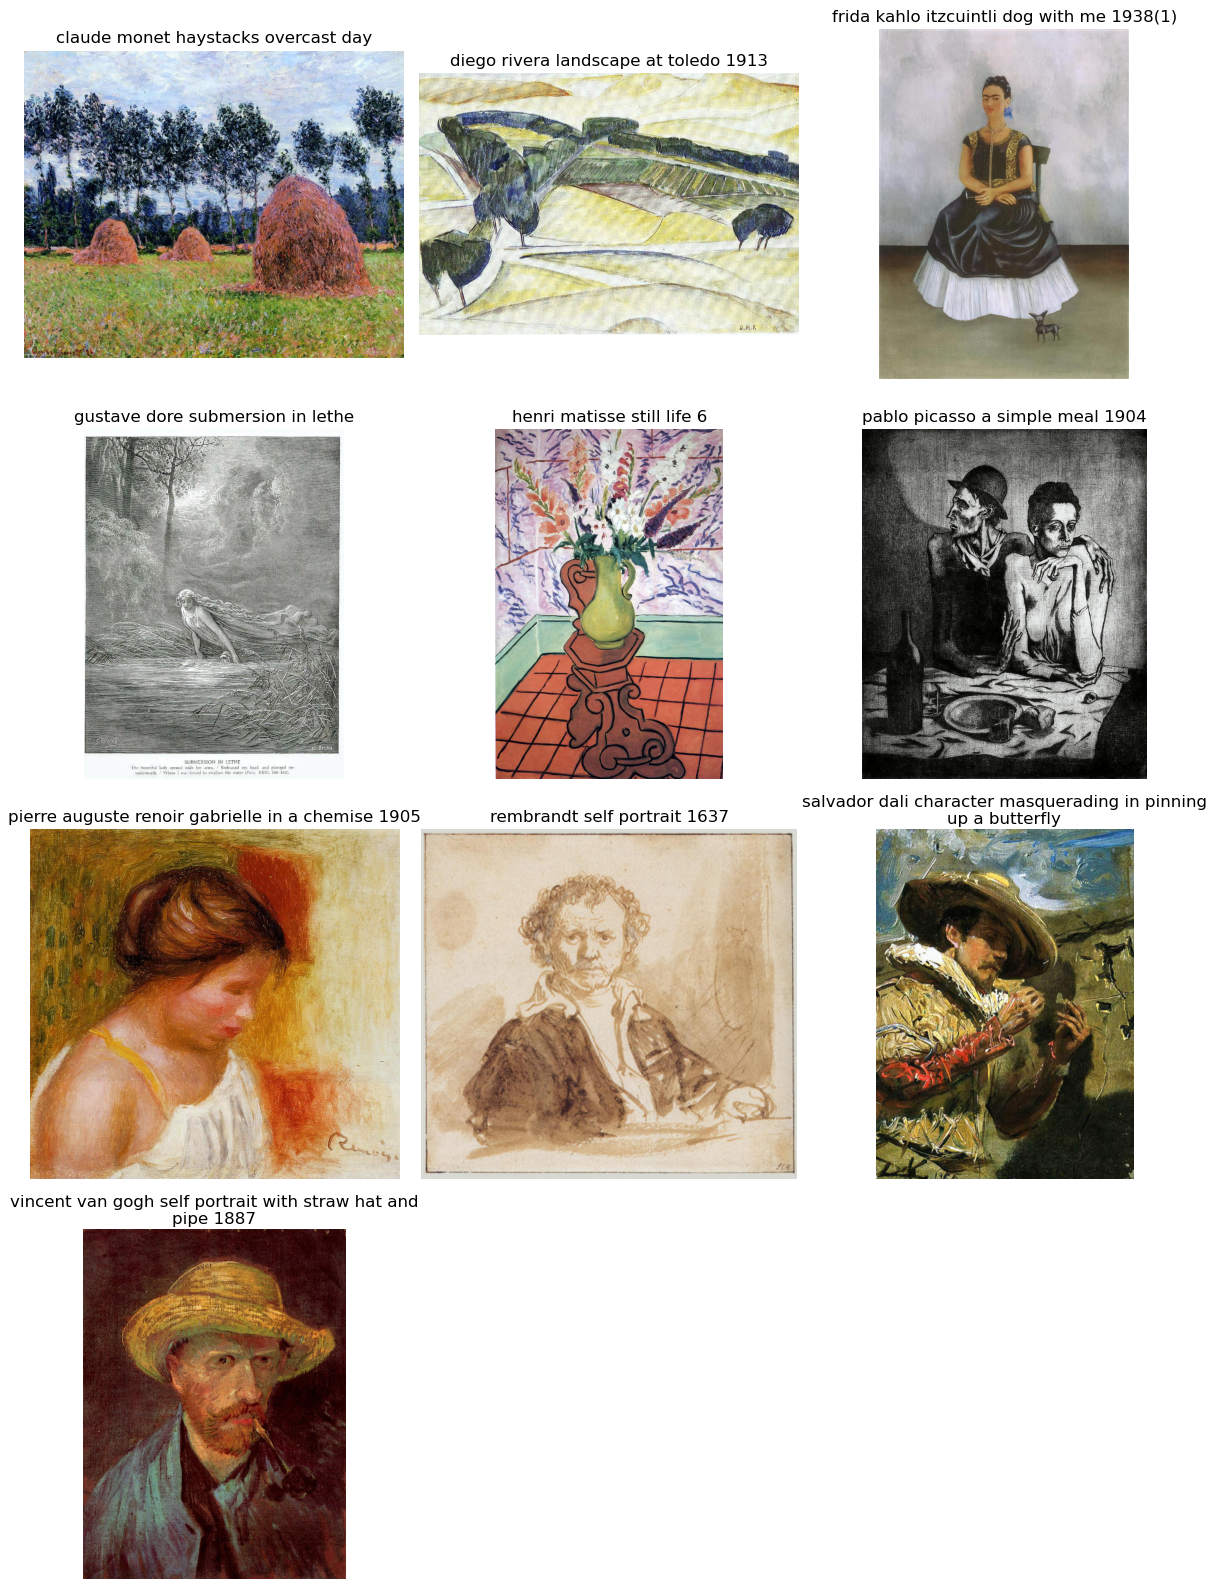

In [38]:
#Cargar y mostrar imagenes
data_folder = "data/images/"
extension = ".jpg"
files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(extension)]

cols = 3
rows = int(np.ceil(len(files) / cols))
plt.figure(figsize=(12, 4 * rows))
for i, p in enumerate(files, 1):
    img_name = os.path.basename(p).replace("_", " ").replace("-", " ").replace(".jpg", "")
    img = Image.open(p)
    plt.subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_name, wrap=True)
plt.tight_layout()
plt.show()

2. Preparación de las imágenes para el entrenamiento y prueba del modelo. Para este paso construir un pipeline que integre las transformaciones que se consideren adecuadas.

In [39]:
#Función para cargar imagenes y convertirlas a formato RGB
def load_rgb(path: str) -> np.ndarray:
    img = Image.open(path).convert("RGB")
    return np.array(img, dtype=np.uint8)

#Función para redimensionar imagenes manteniendo la relación de aspecto
def resize_rgb(img: np.ndarray, max_side: int = MAX_SIDE) -> np.ndarray:
    h, w, _ = img.shape
    scale = min(1.0, max_side / max(w, h))
    
    if scale < 1.0:
        img_pil = Image.fromarray(img)
        img_resized = img_pil.resize((int(w*scale), int(h*scale)))
        return np.array(img_resized, dtype=np.uint8)
    return img

# función para convertir imagen a matriz de pixeles
def image_to_pixel_matrix(img_uint8: np.ndarray) -> np.ndarray:
    X = img_uint8.reshape(-1, 3)
    return X

#Función del pipeline de tratamiento de imagenes (cargar, redimensionamiento y conversión a matriz de pixeles)
def load_and_process_image_pipeline(path: str) -> tuple[np.ndarray, np.ndarray]:
    img = load_rgb(path)
    img_resized = resize_rgb(img)
    pixel_matrix = image_to_pixel_matrix(img_resized)
    return img_resized, pixel_matrix

3. Desarrollo del modelo de agrupación para identificar los colores dominantes en una imagen.
Construcción del modelo de agrupación con el algoritmo seleccionado con búsqueda de hiperparámetros, validándolo con medidas de evaluación adecuadas. Se justifica la selección del algoritmo y las métricas empleadas. Importante: el número de grupos debe ajustarse a las características de las imágenes, es un valor que varía, no es fijo. Es decir, el método debe construir un modelo de agrupación para cada imagen de entrada.

- Para este paso se implementó el algoritmo KMeans, con búsqueda de hiperparámetros a través de la función `hyperparameter_search`, validando los resultados con las métricas de evaluación: silhouette score, calinski harabasz score y davies bouldin score. La selección de estos algoritmos se justifica por su eficacia en la identificación de grupos en conjuntos de datos con características similares a las presentes en las imágenes, así como por su capacidad para manejar grandes volúmenes de datos de manera eficiente. Las métricas seleccionadas permiten evaluar la calidad de los agrupamientos generados, proporcionando una visión integral de la cohesión y separación de los grupos identificados.
- 

In [91]:
# Busqueda de hiperparámetros para el modelo de agrupación
def hyperparameter_search(pixel_matrix: np.ndarray, model_name: str, k_min: int, k_max: int) -> tuple[Pipeline, dict]:
    el_scores: list = []
    sl_scores: list = []
    ch_scores: list = []
    db_scores: list = []

    if model_name == "kmeans":
        model = KMeans(random_state=RAMDOM_STATE)
    elif model_name == "affinity_propagation":
        model = AffinityPropagation(random_state=RAMDOM_STATE)
    else:
        raise ValueError("Model name must be 'kmeans' or 'affinity_propagation'")
    
    pipeline = Pipeline(steps=[("model", model)], memory="cache").set_output(transform="pandas")

    if model_name == "affinity_propagation":
        pipeline.fit_predict(pixel_matrix)
        labels = model.labels_
        el_scores.append(model.inertia_)
        sl_scores.append(silhouette_score(pixel_matrix, labels, sample_size=1000, random_state=RAMDOM_STATE))
        ch_scores.append(calinski_harabasz_score(pixel_matrix, labels))
        db_scores.append(davies_bouldin_score(pixel_matrix, labels))
        return pipeline, {"elbow": el_scores, "silhouette": sl_scores, "calinski_harabasz": ch_scores, "davies_bouldin": db_scores }    
    else:
        for k in range(k_min, k_max + 1):
            
            pipeline.set_params(model__n_clusters = k)
            pipeline.fit_predict(pixel_matrix)
            
            labels = model.labels_
            el_scores.append(model.inertia_)
            sl_scores.append(silhouette_score(pixel_matrix, labels, sample_size=1000, random_state=RAMDOM_STATE))
            ch_scores.append(calinski_harabasz_score(pixel_matrix, labels))
            db_scores.append(davies_bouldin_score(pixel_matrix, labels))

        return pipeline, {"elbow": el_scores, "silhouette": sl_scores, "calinski_harabasz": ch_scores, "davies_bouldin": db_scores }

def plot_hyperparameter_search_results(results: dict, k_min: int, k_max: int, model_name: str):
    ks = list(range(k_min, k_max + 1))
    x_label = "Número de Grupos (k)"
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(ks, results["elbow"], marker='o')
    plt.title(f"{model_name} - Elbow Method")
    plt.xlabel(x_label)
    plt.ylabel("Inertia")
    plt.grid()
    
    plt.subplot(2, 2, 2)
    plt.plot(ks, results["silhouette"], marker='o')
    plt.title(f"{model_name} - Silhouette Score")
    plt.xlabel(x_label)
    plt.ylabel("Silhouette Score")
    plt.grid()
    
    plt.subplot(2, 2, 3)
    plt.plot(ks, results["calinski_harabasz"], marker='o')
    plt.title(f"{model_name} - Calinski-Harabasz Score")
    plt.xlabel(x_label)
    plt.ylabel("Calinski-Harabasz Score")
    plt.grid()
    
    plt.subplot(2, 2, 4)
    plt.plot(ks, results["davies_bouldin"], marker='o')
    plt.title(f"{model_name} - Davies-Bouldin Score")
    plt.xlabel(x_label)
    plt.ylabel("Davies-Bouldin Score")
    plt.grid()
    
    plt.tight_layout()
    plt.show()

#Pipeline de preprocesamiento y análisis de imagenes
def pre_processing_analysis_pipeline(file_path: str, model_name: str, k_min: int, k_max: int) -> tuple[Pipeline, np.ndarray, np.ndarray]:
    image_resized, pixel_matrix = load_and_process_image_pipeline(file_path)
    pipeline, hiperparameter_results = hyperparameter_search(pixel_matrix, model_name, k_min, k_max)
    plot_hyperparameter_search_results(hiperparameter_results, k_min, k_max, pipeline.get_params()["model"].__class__.__name__)
    return pipeline, image_resized, pixel_matrix

In [ ]:
#Extracción de paleta de colores y clasificación de pixeles
def extract_color_palette(pixel_matrix: np.ndarray, pipeline: Pipeline, k: int) -> tuple[np.ndarray, np.ndarray]:

    pipeline.set_params(model__n_clusters = k)
    pipeline.fit_predict(pixel_matrix)
    
    return pipeline.get_params()["model"].labels_, pipeline.get_params()["model"].cluster_centers_.astype(np.uint8)

#Visualización de la paleta de colores
def plot_color_palette(palette: np.ndarray, title: str):
    plt.figure(figsize=(4, 2))
    plt.imshow([palette], aspect='auto')
    plt.axis('off')
    plt.title(title)
    plt.show()

#Reducción de la imagen original utilizando la paleta de colores extraída
def image_reduction(img_resized: np.ndarray, labels: np.ndarray, color_palette: np.ndarray) -> np.ndarray:
    new_img = color_palette[labels].reshape(img_resized.shape)
    return new_img.astype(np.uint8)

#Visualización de la imagen original comparando con la imagen reducida
def plot_image_comparison(img_resized: np.ndarray, img_reduced: np.ndarray):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized)
    plt.title("Imagen Original")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(img_reduced)
    plt.title("Imagen Reducida")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

#Pipeline de post-procesamiento para extracción de paleta de colores, reducción de imagen y visualización comparativa
def post_processing_pipeline(pipeline: Pipeline, img_resized: np.ndarray, pixel_matrix: np.ndarray, k: int):
    labels, color_palette = extract_color_palette(pixel_matrix, pipeline, k)
    plot_color_palette(color_palette, f"Paleta de Colores - {pipeline.get_params()['model'].__class__.__name__}")
    img_reduced = image_reduction(img_resized, labels, color_palette)
    plot_image_comparison(img_resized, img_reduced)


- A continuación se muestra un ejemplo de la aplicación del método para una de las imágenes seleccionadas. Primero se carga la imagen, se procesa y se realiza la búsqueda de hiperparámetros para el algoritmo KMeans. Luego se visualizan los resultados obtenidos.

Analizando imagen: claude-monet_haystacks-overcast-day.jpg


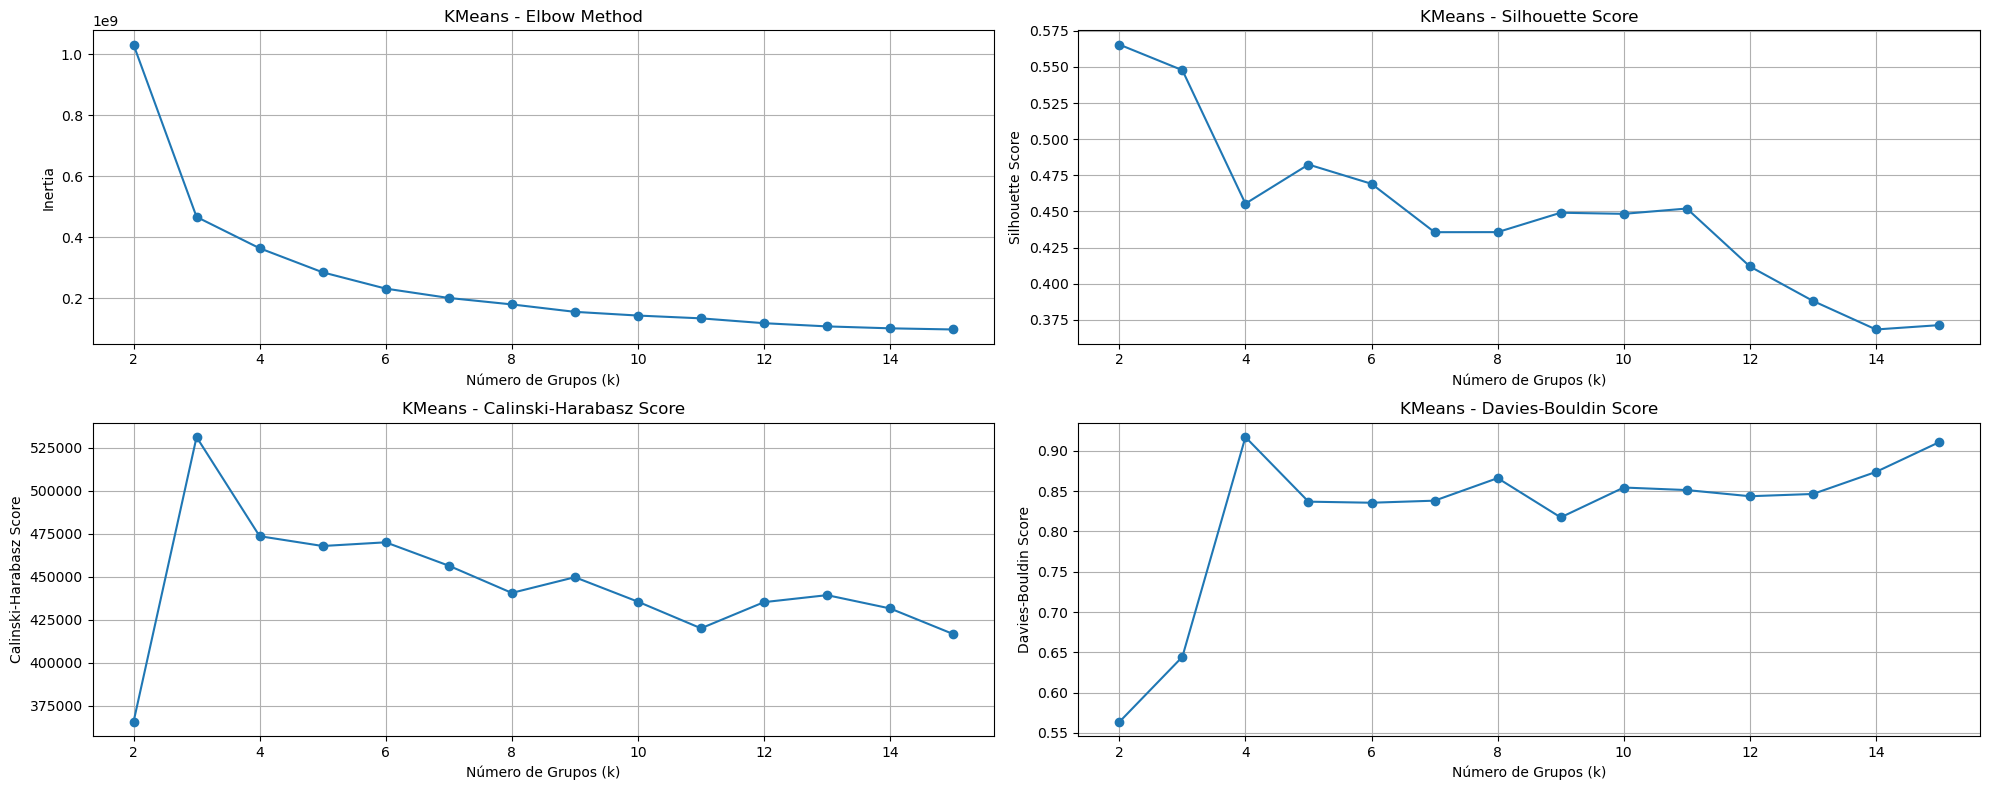

In [92]:
index = 0
file_path = files[index]
print(f"Analizando imagen: {os.path.basename(file_path)}"   )
pipeline, img_resized, pixel_matrix = pre_processing_analysis_pipeline(file_path, "kmeans", 2, 15)

- Para la imagen seleccionada, el método identificó que el número óptimo de grupos es 4, lo que indica que hay cuatro colores dominantes presentes en la imagen. La paleta de colores generada a partir de estos grupos muestra los tonos más representativos, lo que puede ser útil para diversas aplicaciones creativas y analíticas.

- Una vez seleccionado el número óptimo de grupos, se ejecuta el proceso de agrupación para el K seleccionado para luego mostrar la paleta de colores generada a partir de los grupos identificados, por el algoritmo.


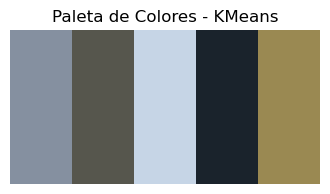

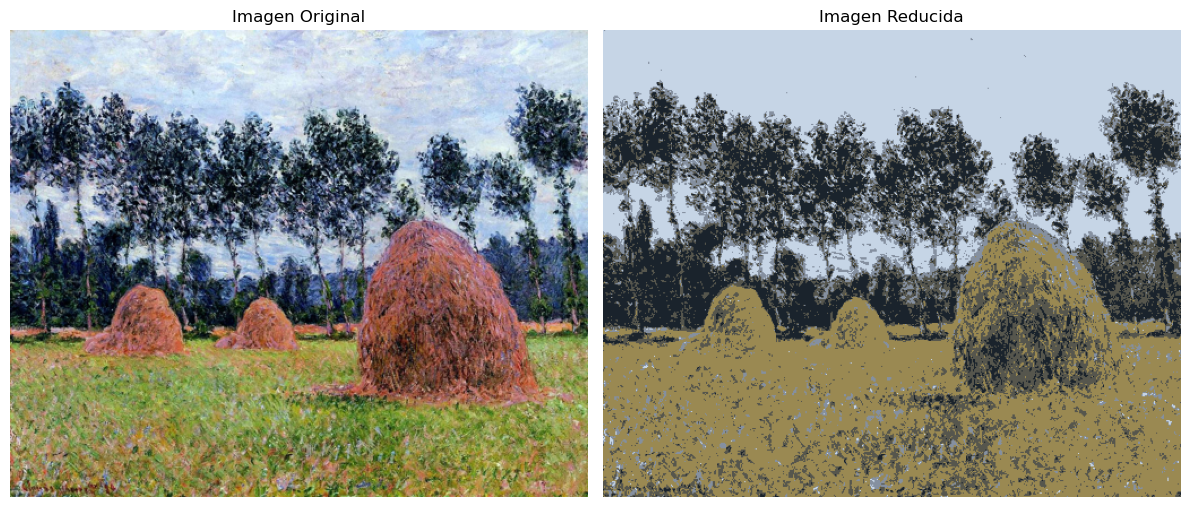

In [78]:
post_processing_pipeline(pipeline, img_resized, pixel_matrix, 5)

Analizando imagen: henri-matisse_still-life-6.jpg


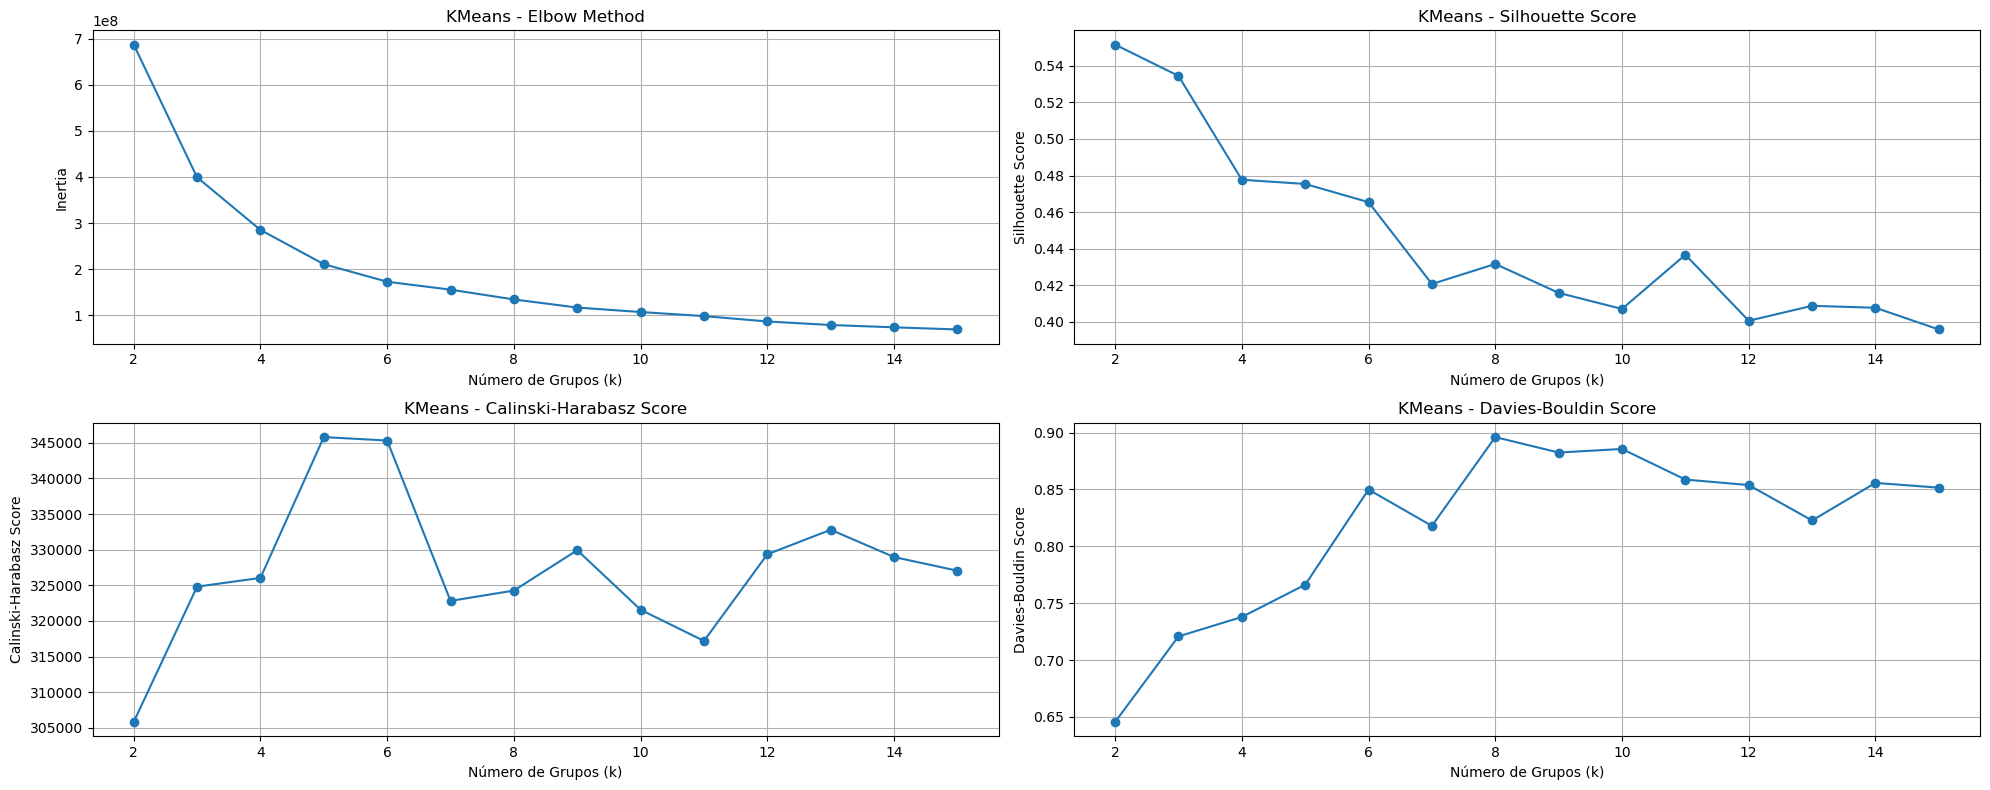

In [93]:
index = 4
file_path = files[index]
print(f"Analizando imagen: {os.path.basename(file_path)}"   )
pipeline, img_resized, pixel_matrix = pre_processing_analysis_pipeline(file_path, "kmeans", 2, 15)

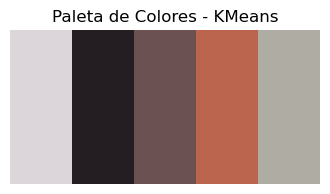

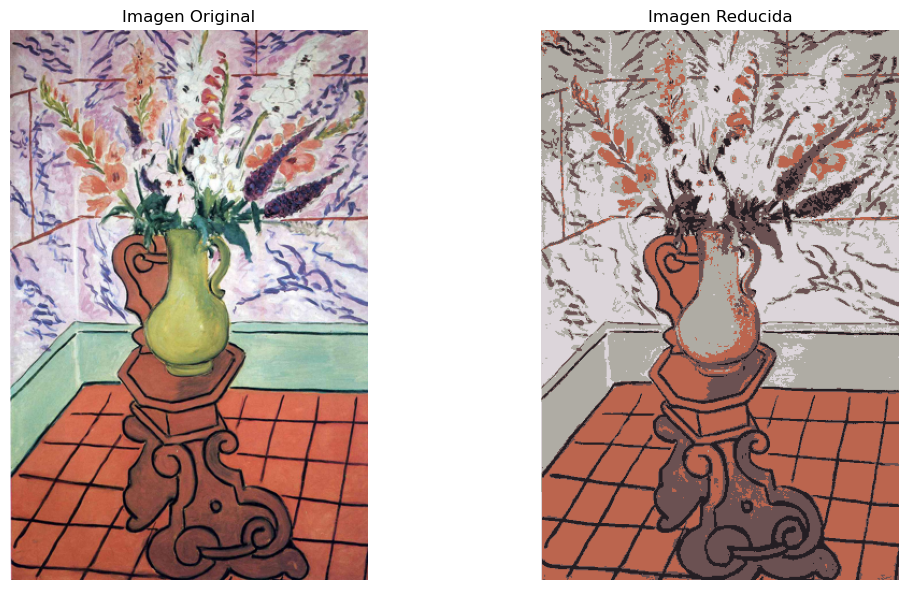

In [94]:
post_processing_pipeline(pipeline, img_resized, pixel_matrix, 5)